In [1]:
import pandas as pd 
import seaborn as sns 
import matplotlib as plt

In [2]:
train_data = pd.read_csv('C:/Users/JustinOkeke/Downloads/Training.csv')

train_data.head(10) # looking at the first few rows of data 
total_columns = len(train_data.columns)
total_rows = len(train_data['prognosis'])
prognoses = train_data['prognosis'].unique().tolist()

print(f"The training dataset has a total of {total_rows} rows and {total_columns} columns. This means that there are {total_columns - 1} predictor variables. \nwithin the prognosis column, there are {len(prognoses)} diseases included.")

The training dataset has a total of 4920 rows and 134 columns. This means that there are 133 predictor variables. 
within the prognosis column, there are 41 diseases included.


In [4]:
# Looking at the distribution of the prognoses within the dataset - determining if there is an imbalance 
100 * train_data.groupby('prognosis').size()/train_data.shape[0] # seems like everything is evenly balanced 

train_data['prognosis'] = train_data['prognosis'].str.title() # Making things look nicer for plotting 

In [6]:
value_columns = train_data.columns.difference(['prognosis', 'Unnamed: 133']).tolist()

# repeat this process for every disease basically


melted_train_data = train_data.melt(id_vars=['prognosis'], value_vars=value_columns).groupby(['prognosis', 'variable']).sum('value')

melted_train_data = melted_train_data[melted_train_data['value'] > 0]


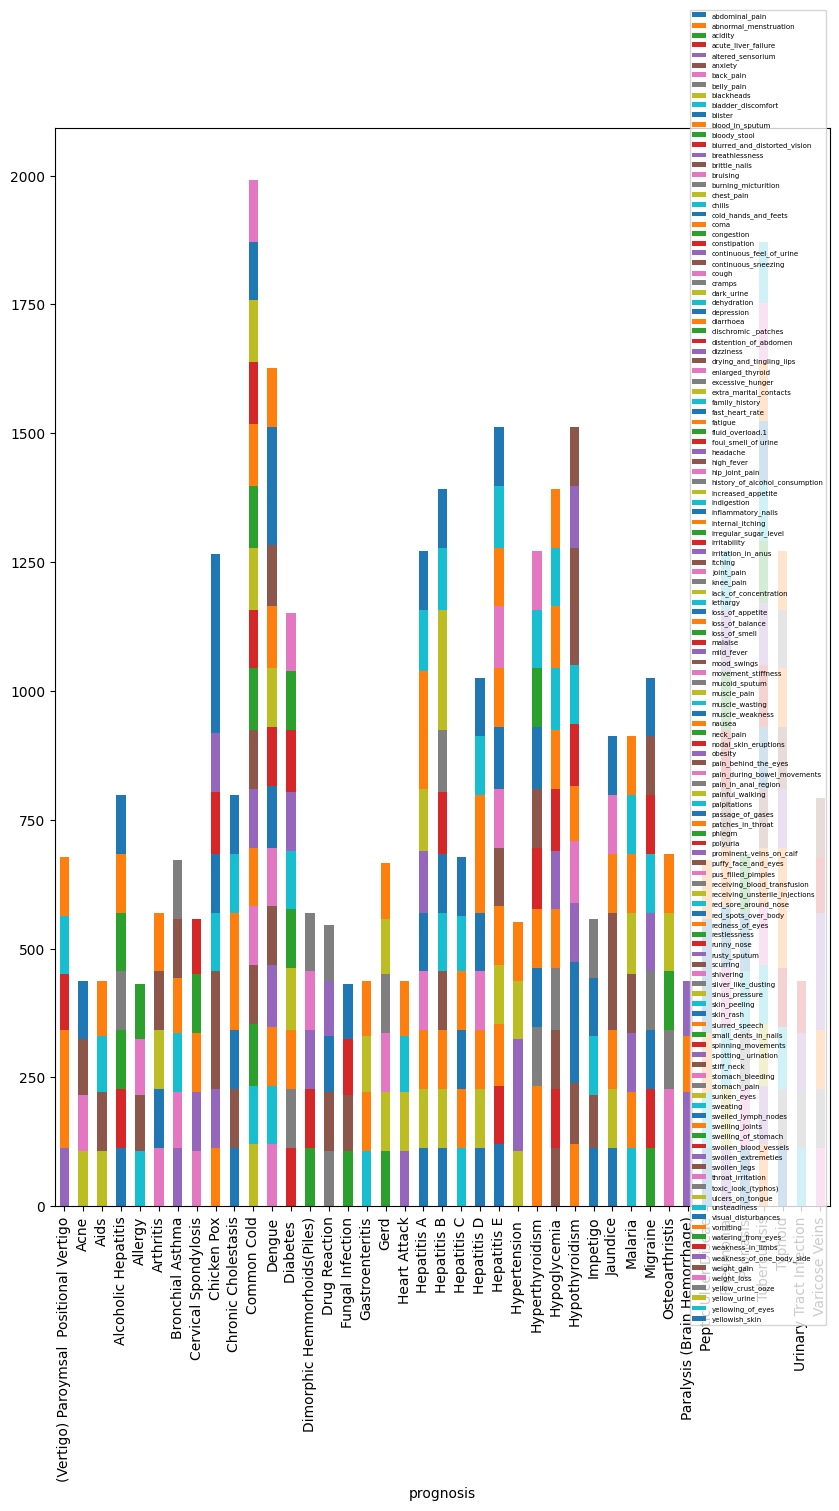

In [7]:
melted_train_data = train_data.melt(id_vars=['prognosis'], value_vars=value_columns)

melted_train_data = melted_train_data[melted_train_data['value'] > 0]
ax = melted_train_data.groupby(['prognosis', 'variable'])['value'].sum().unstack().plot(kind='bar', stacked=True, figsize=[10,14])
ax.legend(loc='right', fontsize=5)


                       itching  skin_rash  nodal_skin_eruptions  \
itching               1.000000   0.318158              0.326439   
skin_rash             0.318158   1.000000              0.298143   
nodal_skin_eruptions  0.326439   0.298143              1.000000   
continuous_sneezing  -0.086906  -0.094786             -0.032566   
shivering            -0.059893  -0.065324             -0.022444   
...                        ...        ...                   ...   
inflammatory_nails   -0.061573   0.331087             -0.023073   
blister              -0.061573   0.331087             -0.023073   
red_sore_around_nose -0.061573   0.331087             -0.023073   
yellow_crust_ooze    -0.061573   0.331087             -0.023073   
Unnamed: 133               NaN        NaN                   NaN   

                      continuous_sneezing  shivering    chills  joint_pain  \
itching                         -0.086906  -0.059893 -0.175905   -0.160650   
skin_rash                       -0.0947

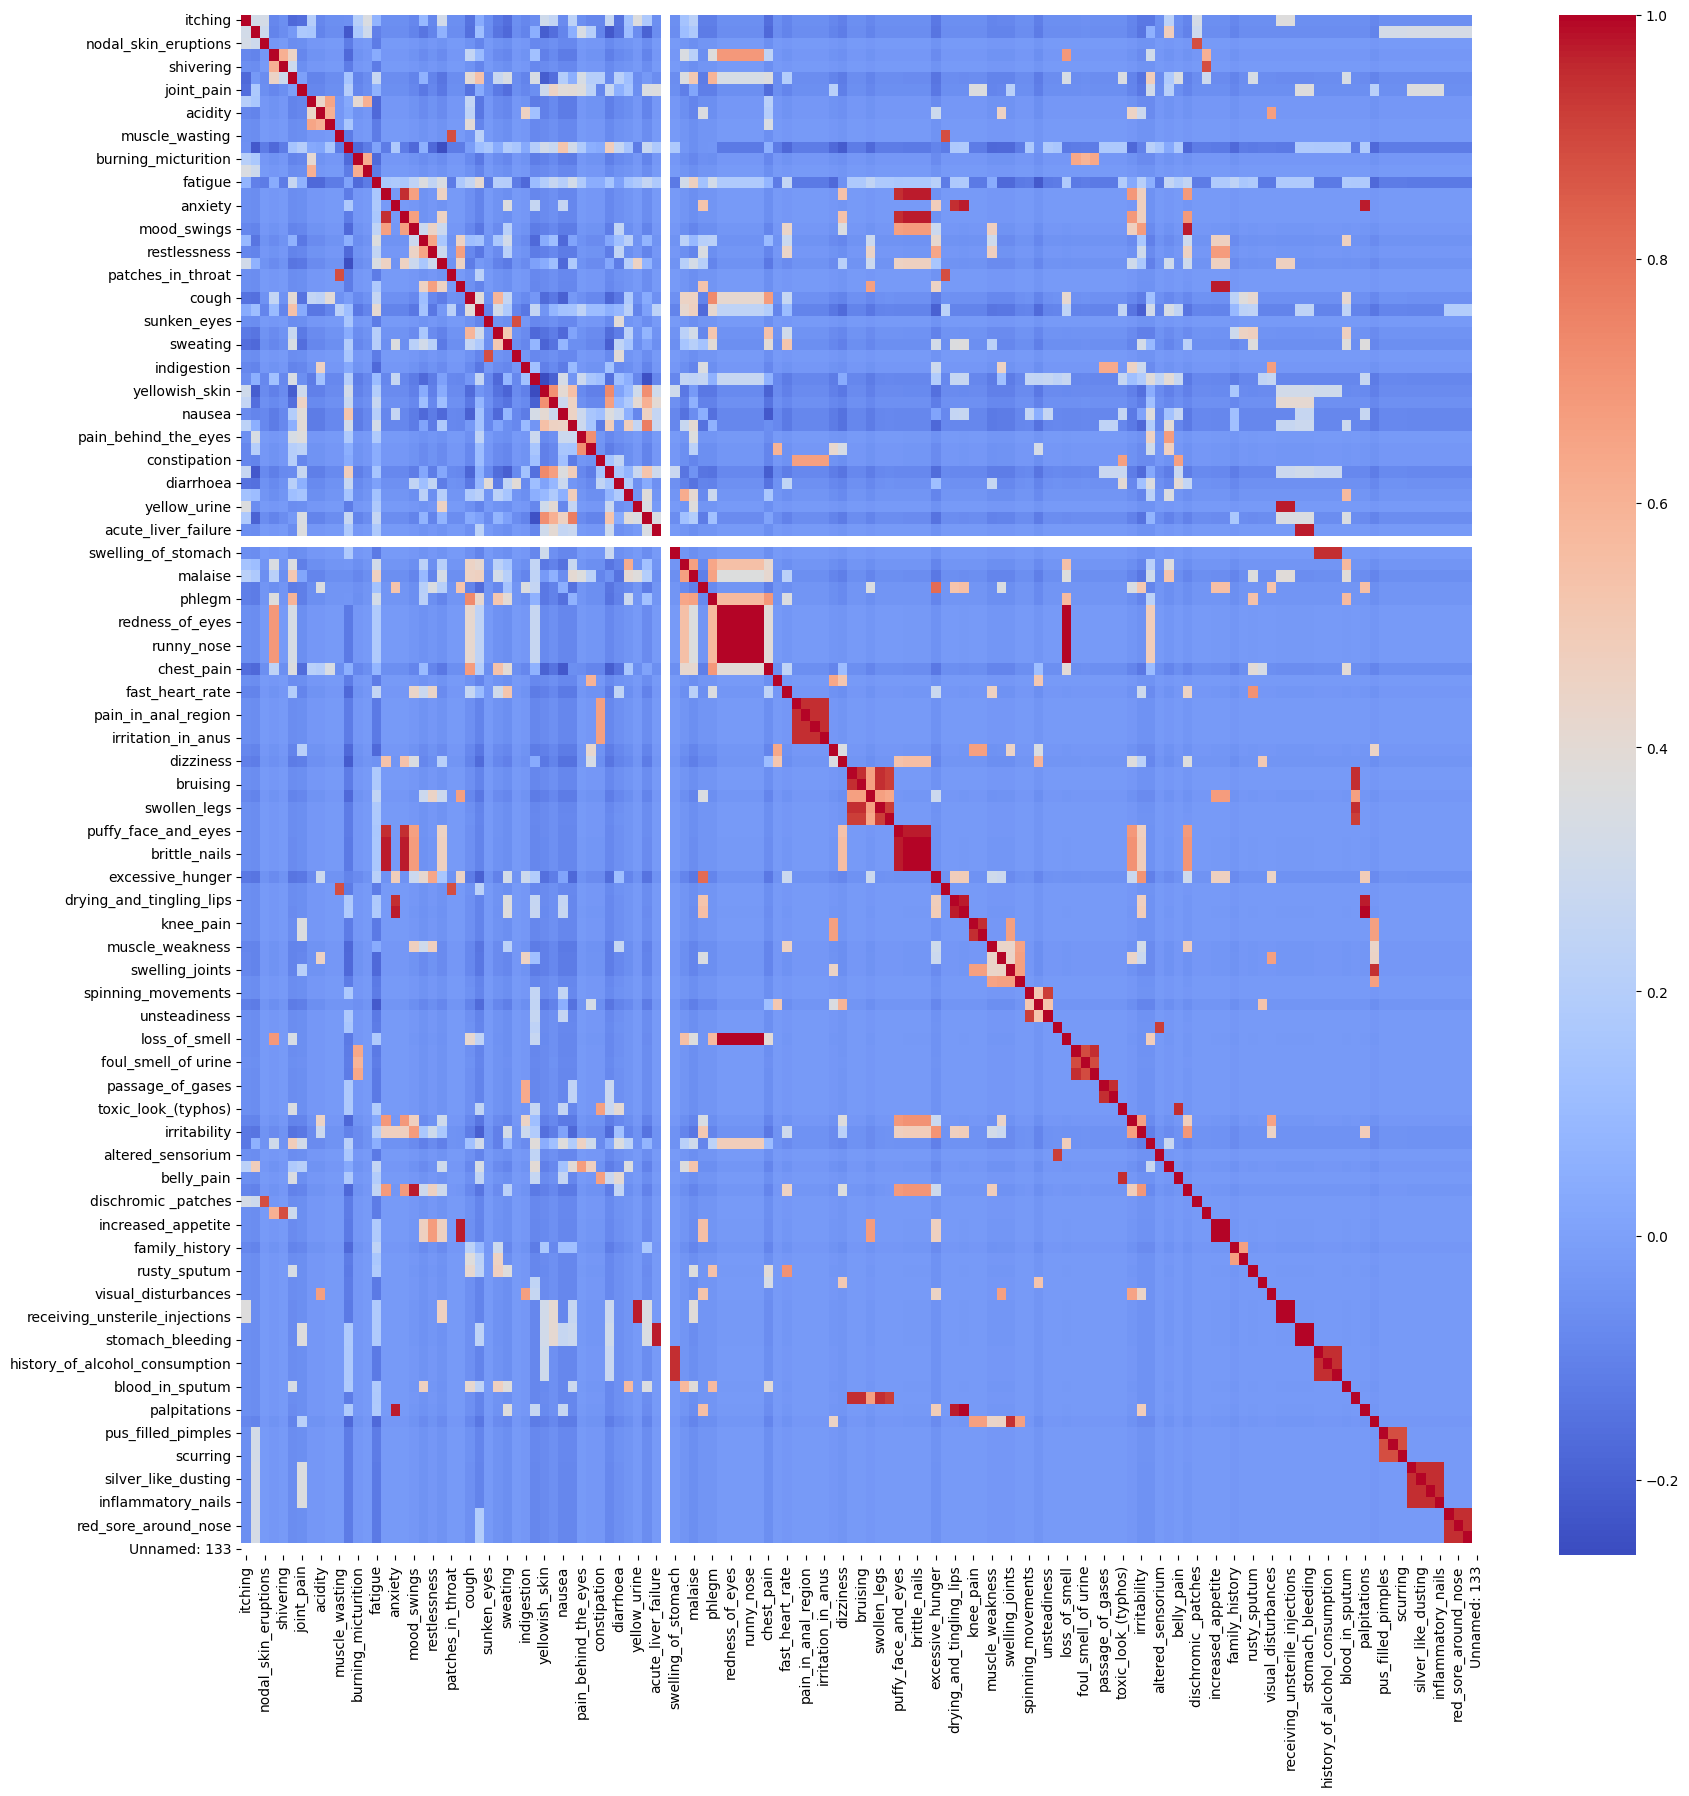

In [8]:
# Next the concept is to create a correlation matrix between the variables 
print(train_data.corr(numeric_only=True))
plt.pyplot.figure(figsize=(20,20))
sns.set_context(rc={"figure.figsize": (20,20)})
heat_plot = sns.heatmap(train_data.corr(numeric_only=True), annot=False, cmap=sns.color_palette("coolwarm", as_cmap=True))

plt.pyplot.show()